<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/4_evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Evaluation Metrics

Churn is when customers stop using the services of a company. Thus, churn prediction
is about identifying customers who are likely to cancel their contracts soon.

If the company can do that, it can offer discounts on these services in an effort to
keep the users.

Imagine that we are working at a telecom company that offers phone and internet
services, and we have a problem: some of our customers are churning. They no longer
are using our services and are going to a different provider. 

We would like to prevent
that from happening, so we develop a system for identifying these customers and offer
them an incentive to stay. 

We want to target them with promotional messages and give
them a discount. We also would like to understand why the model thinks our customers
churn, and for that, we need to be able to interpret the model’s predictions.

In this notebook, we will discuss the ways of evaluating a binary classification model: 

* accuracy
* confusion table
* precision 
* recall
* ROC curve
* AUC

##Setup

In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/blastchar/telco-customer-churn
kaggle datasets download -d blastchar/telco-customer-churn

unzip -qq telco-customer-churn.zip
rm -rf telco-customer-churn.zip

##Dataset

In [5]:
# let’s read our dataset
data_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
len(data_df)

7043

In [6]:
# so, let's set the missing values to zero
data_df["TotalCharges"] = pd.to_numeric(data_df.TotalCharges, errors="coerce")
data_df["TotalCharges"] = data_df["TotalCharges"].fillna(0)

In [7]:
# Let’s make the column names uniform by lowercasing everything and replacing spaces with underscores
data_df.columns = data_df.columns.str.lower().str.replace(" ", "_")
string_columns = list(data_df.dtypes[data_df.dtypes == "object"].index)

for col in string_columns:
  data_df[col] = data_df[col].str.lower().str.replace(" ", "_")

In [8]:
# so, let’s convert the target variable to numbers
data_df.churn = (data_df.churn == "yes").astype(int)

In [9]:
# split such that 80% of the data goes to the train set and the remaining 20% goes to the test set.
df_train_full, df_test = train_test_split(data_df, test_size=0.2, random_state=1)

In [10]:
# let's split it one more time into train and validation
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

In [11]:
# Takes the column with the target variable, churn, and saves it outside the dataframe
y_train = df_train.churn.values
y_val = df_val.churn.values

In [12]:
# Deletes the churn columns
del df_train["churn"]
del df_val["churn"]

In [13]:
# let's create two lists for categorical and numerical variables
categorical_cols = [
  'gender', 'seniorcitizen', 'partner', 'dependents',
  'phoneservice', 'multiplelines', 'internetservice',
  'onlinesecurity', 'onlinebackup', 'deviceprotection',
  'techsupport', 'streamingtv', 'streamingmovies',
  'contract', 'paperlessbilling', 'paymentmethod'
]

numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']

In [14]:
# convert dataframe to a list of dictionaries
train_dict = df_train[categorical_cols + numerical_cols].to_dict(orient="records")

In [15]:
# convert the list of dictionaries to matrix
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
x_train = dv.transform(train_dict)

##Classification model

In [16]:
model = LogisticRegression(solver="liblinear", random_state=1)
model.fit(x_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [22]:
# perform one-hot encoding in exactly the same way as during training
val_dict = df_val[categorical_cols + numerical_cols].to_dict(orient="records")
x_val = dv.transform(val_dict)

y_pred = model.predict_proba(x_val)[:, 1]

In [23]:
subset = ["contract", "tenure", "totalcharges"]
train_dict_small = df_train[subset].to_dict(orient="records")
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

x_small_train = dv_small.transform(train_dict_small)

In [24]:
# Let’s train the small model on this set of features
model_small = LogisticRegression(solver="liblinear", random_state=1)
model_small.fit(x_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [25]:
# let's validate this model
val_dict_small = df_val[subset].to_dict(orient="records")

x_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(x_small_val)[:, 1]

##Classification accuracy

This accuracy is the simplest way to evaluate a classifier: by counting the number of
cases in which our model turned out to be right.

Computing accuracy on the validation dataset is easy — we simply calculate the
fraction of correct predictions:

In [26]:
# Gets the predictions from the model
y_pred = model.predict_proba(x_val)[:, 1]

# Makes "hard" predictions
churn = y_pred >= .5

# Computes the accuracy
(churn == y_val).mean()

0.8016129032258065

Now we can loop over different thresholds and check which one gives the best accuracy:

In [30]:
# Creates an array with different thresholds
thresholds = np.linspace(0, 1, 21)
accuracies = []

for threshold in thresholds:
  churn = y_pred >= threshold
  acc = accuracy_score(y_val, churn)
  accuracies.append(acc)
  print(f"{threshold:.2f} >> {acc:.3f}")

0.00 >> 0.261
0.05 >> 0.501
0.10 >> 0.595
0.15 >> 0.640
0.20 >> 0.690
0.25 >> 0.730
0.30 >> 0.755
0.35 >> 0.767
0.40 >> 0.782
0.45 >> 0.795
0.50 >> 0.802
0.55 >> 0.790
0.60 >> 0.790
0.65 >> 0.788
0.70 >> 0.774
0.75 >> 0.752
0.80 >> 0.742
0.85 >> 0.739
0.90 >> 0.739
0.95 >> 0.739
1.00 >> 0.739


As we see, using the threshold of 0.5 gives us the best accuracy. 

In [42]:
max(accuracies)

0.8016129032258065

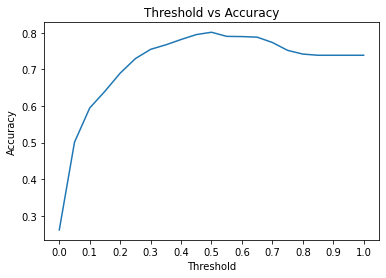

In [49]:
# Let's plot these values
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies)
plt.title("Threshold vs Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

plt.xticks(np.linspace(0, 1, 11))
plt.show()

So, the best threshold is `0.5`, and the best accuracy for this model that we can achieve is `80%`.

In [50]:
# Let’s also check small model's accuracy.
churn_small = y_pred_small >= .5

# Calculates the accuracy of the predictions
accuracy_score(y_val, churn_small)

0.7672043010752688

So, the large model is actually `4%` more accurate than the small model.


In our example, the dataset is imbalanced, and we don’t have many churned users.

So, the dummy model can always predict the majority class — “no churn.”

In [52]:
# Let’s create this baseline prediction
size_val = len(y_val)

baseline = np.repeat(False, size_val)

# check the accuracy of this baseline prediction
accuracy_score(baseline, y_val) 

0.7387096774193549

This means that the accuracy of the baseline
model is around `74%`.

As we see, the small model is only `2%` better than the naive baseline, and the large one is `6%` better.

Churn prediction is a complex problem, and maybe this improvement is great.
However, that’s not evident from the accuracy score alone. 

According to accuracy, our model is only slightly better than a dummy model that treats all the customers as nonchurning
and doesn’t attempt to keep any of them.

Thus, we need other metrics — other ways of measuring the quality of our model.

##Confusion matrix

In [ ]:
pred

array([[0.92667889, 0.07332111],
       [0.16783434, 0.83216566]])

In [ ]:
# select the first customer's probability of churn
pred[0, 1]

0.07332111085213508

In [ ]:
# select the second customer's probability of churn
pred[1, 1]

0.8321656556545182

In [ ]:
# select the first customer's probability of staying
pred[0, 0]

0.9266788891478649

In [ ]:
# select the second customer's probability of staying
pred[1, 0]

0.16783434434548183

So, we’ve built intuition on how logistic regression works, how to train it with
Scikit-learn, and how to apply it to new data.